In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools

In [ ]:
diting_motion = tf.keras.models.load_model('./DiTingMotionJul.hdf5',compile = False)

In [4]:
import h5py
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from random import shuffle
import matplotlib.pyplot as plt
from numpy.fft import irfft, rfftfreq
from numpy import sqrt, newaxis
from numpy.random import normal
from scipy import signal
import obspy

####################################################
# Functions for reading datasets with a given key
####################################################

def get_from_DiTing(part=None, key=None, h5file_path=''):
    """
    get waveform from DiTing Dataset
    TODO: description
    """
    with h5py.File(h5file_path + 'DiTing330km_part_{}.hdf5'.format(part), 'r') as f:
        dataset = f.get('earthquake/'+str(key))    
        data = np.array(dataset).astype(np.float32)
        up_sample_data = np.zeros([data.shape[0]*2, data.shape[1]])
        for chdx in range(data.shape[1]):
            up_sample_data[:,chdx] = signal.resample(data[:,chdx], len(data[:,chdx]) * 2)
        data = up_sample_data
    return data

def get_from_SCSN_FMP(index, h5file_path=''):
    """
    get waveform from SCSN FMP
    TODO: description
    """
    with h5py.File(h5file_path, 'r') as f:
        data = np.asarray(f['X'][index])
        label = np.asarray(f['Y'][index])
    return data, label

####################################################
# Functions for creating a training instance
####################################################
def get_instance_for_FirstMotionPolarity_training(dataset_name='DiTing',
                                                dataset_path = None,
                                                data_length = 128,
                                                part = None,
                                                key = None,
                                                motion = None,
                                                sharpness = None,
                                                P = None):
    """
    Get training instance for First Motion Polarity training
    """
    half_len = data_length//2
    temp_data_X = np.zeros([int(data_length),2])
    temp_data_Y = np.zeros([2,3])

    reverse_factor = np.random.choice([-1,1])
    rescale_factor = np.random.uniform(low=0.5,high=1.5)

    if dataset_name == 'DiTing':
        data = get_from_DiTing(part = part, key = key, h5file_path = dataset_path)
        p_t = int(P)
        temp_data_X[:,0] = data[p_t - half_len: p_t + half_len, 0]
        if motion == 'U' or motion == 'C':
            if reverse_factor == 1:
                temp_data_Y[0,0] = 1
            else:
                temp_data_Y[0,1] = 1
        elif motion == 'R' or motion == 'D':
            if reverse_factor == 1:
                temp_data_Y[0,1] = 1
            else:
                temp_data_Y[0,0] = 1

        if sharpness == 'I':
            temp_data_Y[1,0] = 1
        else:
            temp_data_Y[1,1] = 1

    elif dataset_name == 'SCSN_FMP':
        p_t = 300
        data, label = get_from_SCSN_FMP(index = key, h5file_path = dataset_path)
        temp_data_X[:,0] = data[p_t - half_len: p_t + half_len]

        if label == 0:
            if reverse_factor == 1:
                temp_data_Y[0,0] = 1
            else:
                temp_data_Y[0,1] = 1
        elif label == 1:
            if reverse_factor == 1:
                temp_data_Y[0,1] = 1
            else:
                temp_data_Y[0,0] = 1
        else:
            temp_data_Y[0,2] = 1
    else:
        print('Dataset Type Not Supported!!!')
        return
    
    temp_data_X[:,0] -= np.mean(temp_data_X[:,0])
    norm_factor = np.max(np.abs(temp_data_X[:,0]))
    if norm_factor == 0:
        pass
    else:
        temp_data_X[:,0] /= norm_factor
    
    temp_data_X[:,0] *= reverse_factor
    temp_data_X[:,0] *= rescale_factor
    
    diff_data = np.diff(temp_data_X[half_len:,0])
    diff_sign_data = np.sign(diff_data)
    temp_data_X[half_len+1:,1] = diff_sign_data[:]
    
    return temp_data_X, temp_data_Y

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# SCSN evaluation

In [5]:
# 在此修改数据集路径
# change path here
SCSN_FMP_DatasetPath = '/mnt/GPT_disk/DL_datasets/SCSN_FM/scsn_p_2000_2017_6sec_0.5r_fm_test.hdf5'
fmp_list = ['U','D','-']

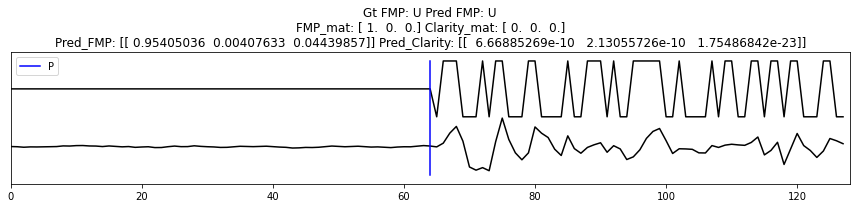

In [8]:
# SCSN test random check
scsn_test_length = 2353054
index_key = np.random.randint(scsn_test_length)
data_length = 128
temp_X, temp_Y = get_instance_for_FirstMotionPolarity_training(dataset_name='SCSN_FMP', dataset_path=SCSN_FMP_DatasetPath, data_length=data_length, key = index_key)

plt.figure(figsize=(12,3))
for chdx in range(2):
    temp_plot = temp_X[:,chdx]
    temp_plot -= np.mean(temp_plot)
    temp_plot /= np.max(np.abs(temp_plot))
    plt.plot(temp_plot + chdx*2, color='k' )
plt.plot([data_length//2,data_length//2],[-1,3],color='b',label='P')
plt.ylim([-1.3,3.3])
plt.xlim([0,temp_plot.shape[0]])
plt.yticks([])

pred_res = diting_motion.predict(temp_X.reshape([1, 128, 2]))
pred_fmp = (pred_res['T0D0'] + pred_res['T0D1'] + pred_res['T0D2'] + pred_res['T0D3']   )/4
pred_cla = (pred_res['T1D0'] + pred_res['T1D1'] + pred_res['T1D2'] + pred_res['T1D3']   )/4
plt.title('Gt FMP: {} Pred FMP: {}\nFMP_mat: {} Clarity_mat: {}\nPred_FMP: {} Pred_Clarity: {}'.format(fmp_list[np.argmax(temp_Y)], fmp_list[np.argmax(pred_fmp[0])] ,temp_Y[0,:], temp_Y[1,:], pred_fmp, pred_cla))
pred_res = diting_motion.predict(temp_X.reshape([1, 128, 2]))
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

In [23]:
# evaluate FMP only
gt_mat = np.zeros([scsn_test_length, 3])
pred_mat = np.zeros([scsn_test_length, 3])

test_batch_size = 5000
test_step = int((scsn_test_length / test_batch_size )) + 1

# test first 20000 !!! as an example
test_step = 4

for t_step in range(test_step):
    t_batch = np.zeros([test_batch_size, data_length, 2])
    for bdx in range(test_batch_size):
        index_key = bdx + t_step*test_batch_size
        if index_key >= scsn_test_length:
            continue
        else:
            temp_X, temp_Y = get_instance_for_FirstMotionPolarity_training(dataset_name='SCSN_FMP', dataset_path=SCSN_FMP_DatasetPath, data_length=data_length, key = index_key)
        t_batch[bdx, :, :] = temp_X[:,:]
        gt_mat[index_key, :] = temp_Y[0,:]
    pred_res = diting_motion.predict(t_batch)
    pred_fmp = (pred_res['T0D0'] + pred_res['T0D1'] + pred_res['T0D2'] + pred_res['T0D3']   )/4
    for bdx in range(test_batch_size):
        if index_key >= scsn_test_length:
            continue
        index_key = bdx + t_step*test_batch_size
        pred_mat[index_key, : ] = pred_fmp[bdx, :]
    print('Done {} of {}'.format(t_step, test_step))

Done 0 of 4
Done 1 of 4
Done 2 of 4
Done 3 of 4


Normalized confusion matrix
[[ 0.99732144  0.00267856]
 [ 0.02518478  0.97481522]]


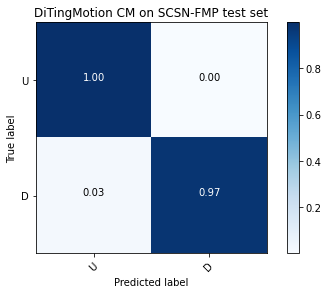

In [24]:
# U D only
true_class = tf.argmax( gt_mat[:,:2], 1 )
predicted_class = tf.argmax( pred_mat[:,:2], 1 )
confusion_matrix = tf.math.confusion_matrix( true_class, predicted_class, 2)
plot_confusion_matrix(confusion_matrix.numpy(), classes=fmp_list[:2], normalize=True, title='DiTingMotion CM on SCSN-FMP test set')

Normalized confusion matrix
[[  9.99585750e-01   7.27505218e-06   4.06974978e-04]
 [  5.74869970e-03   6.91760197e-01   3.02491103e-01]
 [  5.80328906e-02   5.22612271e-02   8.89705882e-01]]


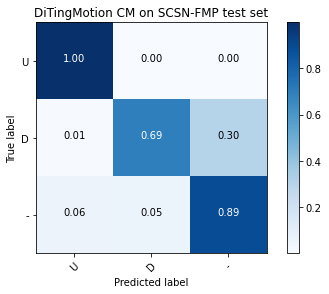

In [25]:
# U D -
true_class = tf.argmax( gt_mat, 1 )
predicted_class = tf.argmax( pred_mat, 1 )
confusion_matrix = tf.math.confusion_matrix( true_class, predicted_class, 3 )
plot_confusion_matrix(confusion_matrix.numpy(), classes=fmp_list, normalize=True, title='DiTingMotion CM on SCSN-FMP test set')

# DiTing evaluation

In [17]:
# 在此修改数据集路径
# change path here
DiTingDatasetPath = '/mnt/GPT_disk/DL_datasets/DiTing330km_publish_50Hz/'
# 加载数据集CSV文件
# load csv file
DiTing_330km_csv = pd.read_csv(DiTingDatasetPath + 'DiTing330km_total.csv',dtype = {'key': str})
DiTing_motion_sub_csv = DiTing_330km_csv.loc[(DiTing_330km_csv.p_motion == 'U') | (DiTing_330km_csv.p_motion == 'D') | (DiTing_330km_csv.p_motion == 'C') | (DiTing_330km_csv.p_motion == 'R')]

/public/home/zhaoming/guochang/miniconda3/envs/DiTingDevEnv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (5,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


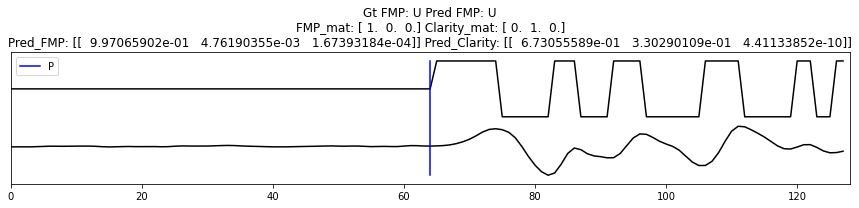

In [18]:
# check waveform and label
diting_test_length = len(DiTing_motion_sub_csv)
random_id = np.random.randint(diting_test_length)
random_line = DiTing_motion_sub_csv.iloc[random_id]

part = random_line['part']
key = random_line['key']
p_t = int(random_line['p_pick']*2)
p_motion =  random_line['p_motion']
p_sharpness = random_line['p_clarity']
data_length = 128
temp_X, temp_Y = get_instance_for_FirstMotionPolarity_training(dataset_name='DiTing', dataset_path=DiTingDatasetPath, data_length=data_length, part = part, key = key, motion=p_motion, sharpness=p_sharpness, P=p_t)

plt.figure(figsize=(12,3))
for chdx in range(2):
    temp_plot = temp_X[:,chdx]
    temp_plot -= np.mean(temp_plot)
    temp_plot /= np.max(np.abs(temp_plot))
    plt.plot(temp_plot + chdx*2, color='k' )
plt.plot([data_length//2,data_length//2],[-1,3],color='b',label='P')
plt.ylim([-1.3,3.3])
plt.xlim([0,temp_plot.shape[0]])
plt.yticks([])

pred_res = diting_motion.predict(temp_X.reshape([1, 128, 2]))
pred_fmp = (pred_res['T0D0'] + pred_res['T0D1'] + pred_res['T0D2'] + pred_res['T0D3']   )/4
pred_cla = (pred_res['T1D0'] + pred_res['T1D1'] + pred_res['T1D2'] + pred_res['T1D3']   )/4
plt.title('Gt FMP: {} Pred FMP: {}\nFMP_mat: {} Clarity_mat: {}\nPred_FMP: {} Pred_Clarity: {}'.format(fmp_list[np.argmax(temp_Y)], fmp_list[np.argmax(pred_fmp[0])] ,temp_Y[0,:], temp_Y[1,:], pred_fmp, pred_cla))
pred_res = diting_motion.predict(temp_X.reshape([1, 128, 2]))
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

In [26]:
# evaluate FMP only
gt_mat = np.zeros([diting_test_length, 3])
pred_mat = np.zeros([diting_test_length, 3])
test_batch_size = 5000
test_step = int((diting_test_length / test_batch_size )) + 1

# test first 20000 !!! as an example
test_step = 4

for t_step in range(test_step):
    t_batch = np.zeros([test_batch_size, data_length, 2])
    for bdx in range(test_batch_size):
        index_key = bdx + t_step*test_batch_size
        choice_line = DiTing_motion_sub_csv.iloc[index_key]

        part = choice_line['part']
        key = choice_line['key']
        p_t = int(choice_line['p_pick']*2)
        p_motion =  choice_line['p_motion']
        p_sharpness = choice_line['p_clarity']        
        
        if index_key >= diting_test_length:
            continue
        else:
            temp_X, temp_Y = get_instance_for_FirstMotionPolarity_training(dataset_name='DiTing', dataset_path=DiTingDatasetPath, data_length=data_length, part = part, key = key, motion=p_motion, sharpness=p_sharpness, P=p_t)
        
        t_batch[bdx, :, :] = temp_X[:,:]
        gt_mat[index_key, :] = temp_Y[0,:]
    pred_res = diting_motion.predict(t_batch)
    pred_fmp = (pred_res['T0D0'] + pred_res['T0D1'] + pred_res['T0D2'] + pred_res['T0D3']   )/4
    for bdx in range(test_batch_size):
        index_key = bdx + t_step*test_batch_size
        if index_key >= diting_test_length:
            continue
        pred_mat[index_key, : ] = pred_fmp[bdx, :]
    print('Done {} of {}'.format(t_step, test_step))

Done 0 of 4
Done 1 of 4
Done 2 of 4
Done 3 of 4


Normalized confusion matrix
[[  9.99629177e-01   3.70823482e-04]
 [  2.54076223e-02   9.74592378e-01]]


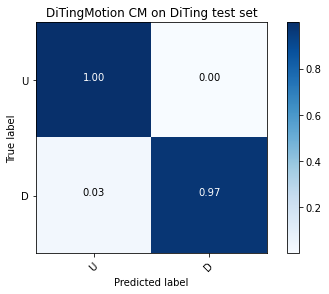

In [27]:
# U D only
true_class = tf.argmax( gt_mat[:,:2], 1 )
predicted_class = tf.argmax( pred_mat[:,:2], 1 )
confusion_matrix = tf.math.confusion_matrix( true_class, predicted_class, 2)
plot_confusion_matrix(confusion_matrix.numpy(), classes=fmp_list[:2], normalize=True, title='DiTingMotion CM on DiTing test set')